In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 65kB/s 
     |████████████████████████████████| 204kB 16.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=6fa7d00137c7cdecc57938490594e2b94a55012e91af6308b3e7f18701486559
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:

from pyspark import SparkConf,SparkContext
from pyspark import mllib as ml
from pyspark.ml.feature import Tokenizer,HashingTF,IDF,StopWordsRemover,CountVectorizer
from pyspark.sql import SparkSession,SQLContext,Row
from pyspark.sql.functions import lower,regexp_replace,trim
from textblob import TextBlob
import string
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,ArrayType
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd

In [ ]:
#Configuring the Spark system, Master = local system.
conf = SparkConf().setMaster("local").setAppName("Project")
sc = SparkContext(conf=conf)

In [ ]:

#Applying SQLContext to the Spark Context.
sqlcontext = SQLContext(sc)

In [ ]:
#Starting a Spark Session
spark = SparkSession(sqlcontext)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading the  data file which is taken from kaggle

city = spark.read.load("/content/drive/MyDrive/BigData /Telecom_Data for 110 cities.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()


In [ ]:

city = city.select("PROVINCIA")
city.createOrReplaceTempView("SURVEY") 

In [ ]:
city.describe().show()

+-------+---------+
|summary|PROVINCIA|
+-------+---------+
|  count|      110|
|   mean|     null|
| stddev|     null|
|    min|Agrigento|
|    max|  Viterbo|
+-------+---------+



In [ ]:

spark.sql("select * from survey").show(100)

+--------------------+
|           PROVINCIA|
+--------------------+
|         Alessandria|
|                Asti|
|              Biella|
|               Cuneo|
|              Novara|
|              Torino|
|Verbano-Cusio-Ossola|
|            Vercelli|
|Valle d'Aosta/Val...|
|             Bergamo|
|             Brescia|
|                Como|
|             Cremona|
|               Lecco|
|                Lodi|
|             Mantova|
|              Milano|
|Monza e della Bri...|
|               Pavia|
|             Sondrio|
|              Varese|
|       Bolzano/Bozen|
|              Trento|
|             Belluno|
|              Padova|
|              Rovigo|
|             Treviso|
|             Venezia|
|              Verona|
|             Vicenza|
|             Gorizia|
|           Pordenone|
|             Trieste|
|               Udine|
|              Genova|
|             Imperia|
|           La Spezia|
|              Savona|
|             Bologna|
|             Ferrara|
|        Fo

In [ ]:

provinces = spark.read.load("/content/drive/MyDrive/BigData /Italian_provinces.geojson.zip",
                    format='json',
                    multiline=True,
                    inferSchema='true').cache()

In [ ]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |   survey|       true|
+--------+---------+-----------+



In [ ]:
network = spark.read.load("/content/drive/MyDrive/BigData /sms-call-internet-mi-2013-11-01.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()

In [ ]:
network.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     1|         33|  null|  null|  null|   null|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|         33|  null|  null|  null|   null|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [ ]:
network.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     1|         33|  null|  null|  null|   null|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|         33|  null|  null|  null|   null|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [ ]:
network.createOrReplaceTempView("network")


In [ ]:
spark.sql("show tables").show()


+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |  network|       true|
|        |   survey|       true|
+--------+---------+-----------+



In [ ]:
aggcountryDF = spark.sql("""select 
                                CASE countrycode
                                    WHEN 7 THEN "Russia"
                                    WHEN 33 THEN "France"
                                    WHEN 34 THEN "Spain"
                                    WHEN 39 THEN "Italy"
                                    WHEN 44 THEN "United Kingdom"
                                    WHEN 47 THEN "Norway"
                                    WHEN 48 THEN "Poland"
                                    WHEN 49 THEN "Germany"
                                    WHEN 351 THEN "Portugal"
                                    WHEN 420 THEN "Czech Republic"
                                    ELSE "_Others_"
                                END as country,
                                round(sum(smsin),6) smsin, 
                                round(sum(smsout),6) smsout, 
                                round(sum(callin),6) callin, 
                                round(sum(callout),6) callout, 
                                round(sum(internet),6) internet
                            from network
                            where countrycode != 0
                            group by country
                            order by 1 """)

In [ ]:
aggcountryDF.show()


+--------------+------------+------------+------------+------------+-----------------+
|       country|       smsin|      smsout|      callin|     callout|         internet|
+--------------+------------+------------+------------+------------+-----------------+
|Czech Republic|   2608.1169|   1437.8024|    733.0263|    544.2075|        5488.8842|
|        France|  20495.0177|  13158.3234|    4527.906|   2984.4441|       36769.9342|
|       Germany|   9549.2932|   2747.5518|   1960.2404|   1396.1923|       23737.9411|
|         Italy|2889250.3153|2688729.4971|2560497.8263|2962224.2957|8.2245208645798E7|
|        Norway|    745.8405|    535.5974|    190.2444|    149.5543|         1913.018|
|        Poland|   3821.9876|   1852.1156|   1176.1172|    861.9467|        3879.9327|
|      Portugal|    616.0036|    358.1073|    288.9737|    128.8219|         459.4812|
|        Russia|   8983.6104|   6108.6568|   4682.9862|    1710.748|        5509.7652|
|         Spain|   2301.3214|   1428.7563| 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
plotdf = aggcountryDF.where("country not in ('Italy','_Others_')").toPandas()
print(plotdf)

          country       smsin      smsout     callin    callout    internet
0  Czech Republic   2608.1169   1437.8024   733.0263   544.2075   5488.8842
1          France  20495.0177  13158.3234  4527.9060  2984.4441  36769.9342
2         Germany   9549.2932   2747.5518  1960.2404  1396.1923  23737.9411
3          Norway    745.8405    535.5974   190.2444   149.5543   1913.0180
4          Poland   3821.9876   1852.1156  1176.1172   861.9467   3879.9327
5        Portugal    616.0036    358.1073   288.9737   128.8219    459.4812
6          Russia   8983.6104   6108.6568  4682.9862  1710.7480   5509.7652
7           Spain   2301.3214   1428.7563  2178.4545  1665.4606  11389.0908
8  United Kingdom  11509.6936  11603.9780  3756.9092  2954.2486  23588.0875


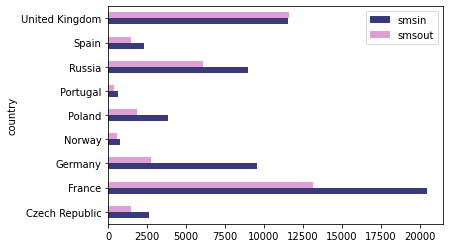

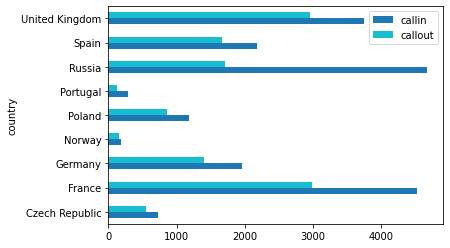

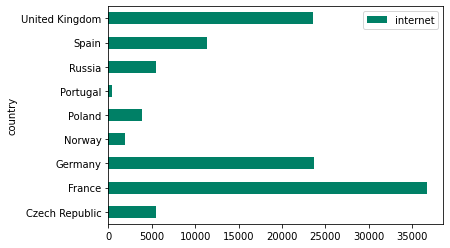

In [ ]:
plotdf.plot(kind='barh', x='country', y=['smsin', 'smsout'], colormap='tab20b')
plotdf.plot(kind='barh', x='country', y=['callin', 'callout'], colormap='tab10')
plotdf.plot(kind='barh', x='country', y=['internet'], colormap='summer')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import datetime


In [ ]:

parse = lambda x: datetime.datetime.fromtimestamp(1000)

fig_width_pt = 345  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
fig_size = [fig_width, fig_height]

sns.set_style("ticks")
sns.set_context("paper")

# Import dataset - Milano
sliceSum = pd.DataFrame({})
for index in range(4,7):
    sliceSum2 = pd.read_csv('/content/drive/MyDrive/BigData /sms-call-internet-mi-2013-11-'+str(index).zfill(2) +'.csv', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)
    sliceSum2 = sliceSum2.set_index('datetime')
    sliceSum2['hour'] = sliceSum2.index.hour
    sliceSum2['weekday'] = sliceSum2.index.weekday
    sliceSum2 = sliceSum2.groupby(['hour', 'weekday', 'CellID'], as_index=False).sum()

    sliceSum = sliceSum.append(sliceSum2)

sliceSum['idx'] = sliceSum['hour'] + (sliceSum['weekday']*24)
sliceSum.head()

# Import dataset Tweets Milano
#social_df = pd.read_csv('nature/result2.csv', sep=',', encoding="utf-8-sig", parse_dates=['created'])
#social_df = social_df.set_index(['created'], drop=False)
#social_df = social_df.groupby([social_df.index.weekday, social_df.index.hour], as_index=False).count()
#social_df['Tweets'] = social_df['created']
#social_df = social_df[['Tweets']]
#social_df.head()

# Group by weekday-hour
sliceSum_city = sliceSum.groupby(['weekday', 'hour'], as_index=False).sum()
sliceSum_city['sms'] = sliceSum_city['smsin'] + sliceSum_city['smsout']
sliceSum_city['calls'] = sliceSum_city['callin'] + sliceSum_city['callout']
sliceSum_city.rename(columns={'sms': 'SMS', 'internet': 'Internet'}, inplace=True)

# Behaviour plot
types = ['SMS', 'calls', 'Internet']
fig_size2 = [fig_width, fig_width*golden_mean*2 ]
f, axs = plt.subplots(len(types), sharex=True, sharey=True,figsize=fig_size2)

# Z-score
#sliceSum_z = (sliceSum_city - sliceSum_city.mean()) / sliceSum_city.std()
#social_df = (social_df - social_df.mean()) / social_df.std()

for i, p in enumerate(types):
    plt.xticks(np.arange(168, step=10))
    if p == 'Tweets':
        axs[i].plot(social_df[p], label=p)
    else:
        axs[i].plot(sliceSum_z[p], label=p)
    axs[i].legend(loc='upper center')
    sns.despine()

f.text(0, 0.5, "Number of events", rotation="vertical", va="center")

plt.xlabel("Hour (in a week)")
plt.savefig('behaviour.pdf', format='pdf', dpi=330,bbox_inches='tight')

# Import dataset Telecommunications - Trentino
sliceSum3 = pd.DataFrame({})
for index in range(4, 7):
    sliceSum2 = pd.read_csv('/content/drive/MyDrive/BigData /sms-call-internet-mi-2013-11-'+str(index).zfill(2) +'.csv', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)
    sliceSum2 = sliceSum2.set_index('datetime')
    sliceSum2['hour'] = sliceSum2.index.hour
    sliceSum2['weekday'] = sliceSum2.index.weekday
    sliceSum2 = sliceSum2.groupby(['hour', 'weekday', 'CellID'], as_index=False).sum()

    sliceSum3 = sliceSum3.append(sliceSum2)

sliceSum3['idx'] = sliceSum3['hour'] + (sliceSum3['weekday']*24)
sliceSum3.head()

# Validation behavioural plots
fig_size2 = [fig_width,fig_width*golden_mean*1.5 ]
fig = plt.figure(figsize=fig_size2)

f, axs = plt.subplots(2, sharex=True, sharey=False, figsize=fig_size2)

axs[0].plot(sliceSum[sliceSum.CellID == 5060].set_index('idx')['internet'], label='Duomo')
axs[0].plot(sliceSum[sliceSum.CellID == 4259].set_index('idx')['internet'], label='Bocconi')
axs[0].plot(sliceSum[sliceSum.CellID == 4456].set_index('idx')['internet'], label='Navigli')
axs[0].set_xticklabels([])
sns.despine()
# Shrink current axis's height by 10% on the bottom
box = axs[0].get_position()
axs[0].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=5)
axs[1].plot(sliceSum3[sliceSum3.CellID == 5200].set_index('idx')['internet'], label='Duomo')
axs[1].plot(sliceSum3[sliceSum3.CellID == 5085].set_index('idx')['internet'], label='Mesiano')
axs[1].plot(sliceSum3[sliceSum3.CellID == 4703].set_index('idx')['internet'], label='Bosco')
# Shrink current axis's height by 10% on the bottom
box = axs[1].get_position()
axs[1].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), fancybox=True, shadow=True, ncol=5)
axs[1].set_xlabel("Weekly hour")
sns.despine()

f.text(0, 0.5, "Absolute number of connections", rotation="vertical", va="center")
plt.savefig('validation-Milano.pdf', format='pdf', dpi=330, bbox_inches='tight')

# Boxplots
boxplots = {
    'calls': "Calls",
    'sms': "SMS",
    "internet": "Internet CDRs"
}
fig_size2 = [fig_width, fig_width*golden_mean*2]
f, axs = plt.subplots(len(boxplots.keys()), sharex=True, sharey=False, figsize=fig_size2)
f.subplots_adjust(hspace=.35,wspace=0.1)
sliceSum['sms'] = sliceSum['smsin'] + sliceSum['smsout']
sliceSum['calls'] = sliceSum['callin'] + sliceSum['callout']
i = 0
plt.suptitle("")

for k, v in boxplots.iteritems():

    ax = sliceSum.reset_index().boxplot(column=k, by='weekday', grid=False, sym='', ax =axs[i])
    axs[i].set_title(v)
    axs[i].set_xlabel("")
    sns.despine()
    i += 1

plt.xlabel("Weekday (0=Monday, 6=Sunday)")
f.text(0, 0.5, "Number of events", rotation="vertical", va="center")
plt.savefig('boxplots-Milano.pdf', format='pdf', dpi=330,bbox_inches='tight')

